In [1]:
import os
os.listdir(r'/kaggle/input/nudtsirst')

['nudtsirst',
 'annotation_train.csv',
 'annotation_test.csv',
 'annotation.csv',
 'mask']

In [2]:
! pip install torch-summary

In [3]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2

from torchsummary import summary

In [5]:
class IRSTDataLoader(torch.utils.data.Dataset):
    def __init__(self, input_path = '/kaggle/input/nudtsirst/nudtsirst/',
                 mask_path  = '/kaggle/input/nudtsirst/mask/',
                 data_transform = transforms.ToTensor()):
        super(IRSTDataLoader, self).__init__()
        sample_list      = os.listdir(mask_path)
        img_list         = [[sample+'/'+a for a in os.listdir(mask_path+sample)] for sample in sample_list]
        img_list = sum(img_list, [])
        
        self.img_list = img_list
        
        self.image_input = [input_path+img_path for img_path in img_list]
        
        self.mask_input = [mask_path+img_path for img_path in img_list]
        
        self.data_transform = data_transform
        
    def __getitem__(self, index):
        img_input = self.image_input[index]
        mask_input = self.mask_input[index]
        
        img = self.data_transform(Image.open(img_input))
        
        mask = self.data_transform(Image.open(mask_input))[0]
        
        #mask = torch.argmax(mask, 0).type(torch.int64)
        
        return img, mask
    
    def __len__(self):
        return len(self.img_list)
        

In [6]:
batch_size = 4

train_size = 0.8

In [7]:
irst_dl = IRSTDataLoader()
train_sz = int(train_size*len(irst_dl))
valid_sz = 200
test_sz  = len(irst_dl) - train_sz - valid_sz

train_set, valid_set, test_set = random_split(irst_dl, [train_sz,valid_sz,test_sz])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=batch_size, shuffle=True)

In [8]:
len(train_set)

33650

In [9]:
for i, (data,targets) in enumerate(train_dataloader):
    #data, targets = data.to(device), targets.to(device)
    d1 = data
    t1 = targets
    break
d1.shape, t1.shape

(torch.Size([4, 3, 1024, 1280]), torch.Size([4, 1024, 1280]))

In [10]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a11b26c800b81bbd3dce6562eb88a80fb818f561be12350862907075754e5e6d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=718683c8f216621304537990139aaffa90ae998bf774db09264656025dea1dfd
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
import segmentation_models_pytorch as smp
from torchsummary import summary

In [13]:
# pretrained_model = smp.Unet(
#     encoder_name="timm-mobilenetv3_large_100",        
#     encoder_weights="imagenet",     
#     classes=1,      
#     decoder_channels=[256, 128, 64, 32, 16]
# )
pretrained_model = smp.FPN("resnet34", 
    encoder_weights='imagenet',
    classes=1,
    activation=None)

summary(pretrained_model.to(device), (3, 1024, 1280))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 1024, 1280]       --
|    └─Conv2d: 2-1                       [-1, 64, 512, 640]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 512, 640]        128
|    └─ReLU: 2-3                         [-1, 64, 512, 640]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 256, 320]        --
|    └─Sequential: 2-5                   [-1, 64, 256, 320]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 256, 320]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 256, 320]        73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 256, 320]        73,984
|    └─Sequential: 2-6                   [-1, 128, 128, 160]       --
|    |    └─BasicBlock: 3-4              [-1, 128, 128, 160]       230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 128, 160]       295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 128, 160

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 1024, 1280]       --
|    └─Conv2d: 2-1                       [-1, 64, 512, 640]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 512, 640]        128
|    └─ReLU: 2-3                         [-1, 64, 512, 640]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 256, 320]        --
|    └─Sequential: 2-5                   [-1, 64, 256, 320]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 256, 320]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 256, 320]        73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 256, 320]        73,984
|    └─Sequential: 2-6                   [-1, 128, 128, 160]       --
|    |    └─BasicBlock: 3-4              [-1, 128, 128, 160]       230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 128, 160]       295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 128, 160

In [15]:
pretrained_model = nn.DataParallel(pretrained_model)
model = pretrained_model.to(device)

In [16]:
epochs = 5

learning_rate = 0.0001
loss_function = smp.losses.DiceLoss(mode = 'binary')

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
display_step = 20

# Model path
checkpoint = 'model.pth'

train_loss_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [17]:
import time

checkpoint = 'model.pth'

def train(train_dataloader, valid_dataloader, epoch, small_step = 250, display_step = 1250):
    print(f"Start epoch #{epoch+1}")
    start_time = time.time()
    step_loss = 0
    train_loss_epoch = 0
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data to GPU
        data, targets = data.to(device), targets.to(device)

        # Clear gradient
        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()*batch_size
        step_loss += loss.item()
        if (i+1) % display_step == 0:
            val_loss = 0
            for _, (val_data,val_targets) in enumerate(valid_dataloader):
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                val_output = model(val_data)
                val_loss_batch   = loss_function(val_output, val_targets.long()).item()
                val_loss += val_loss_batch*batch_size
            print('Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.4f}\tVal loss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                step_loss/small_step, val_loss/len(valid_dataloader)))
            step_loss = 0
            torch.save(model,checkpoint)
        elif (i+1) % small_step == 0:
            print('Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                step_loss/small_step))
            step_loss = 0
            torch.save(model,checkpoint)
            
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")

    return train_loss_epoch/len(train_dataloader)

In [18]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/IRST_train_1')

In [19]:
checkpoint = 'model.pth'
for epoch in range(5):
    train_loss_epoch= train(train_dataloader, valid_dataloader, epoch)
    torch.save(model,checkpoint)

    train_loss_array.append(train_loss_epoch)

Start epoch #1
Train Epoch: 1 [1000/33650 (2.972%)]	Loss: 0.6223
Train Epoch: 1 [2000/33650 (5.944%)]	Loss: 0.2998
Train Epoch: 1 [3000/33650 (8.915%)]	Loss: 0.2632
Train Epoch: 1 [4000/33650 (11.887%)]	Loss: 0.2397
Train Epoch: 1 [5000/33650 (14.859%)]	Loss: 0.2185	Val loss: 0.7972
Train Epoch: 1 [6000/33650 (17.831%)]	Loss: 0.1927
Train Epoch: 1 [7000/33650 (20.802%)]	Loss: 0.1758
Train Epoch: 1 [8000/33650 (23.774%)]	Loss: 0.1584
Train Epoch: 1 [9000/33650 (26.746%)]	Loss: 0.1479
Train Epoch: 1 [10000/33650 (29.718%)]	Loss: 0.1329	Val loss: 0.4956
Train Epoch: 1 [11000/33650 (32.689%)]	Loss: 0.1178
Train Epoch: 1 [12000/33650 (35.661%)]	Loss: 0.1163
Train Epoch: 1 [13000/33650 (38.633%)]	Loss: 0.1113
Train Epoch: 1 [14000/33650 (41.605%)]	Loss: 0.1022
Train Epoch: 1 [15000/33650 (44.577%)]	Loss: 0.1010	Val loss: 0.4018
Train Epoch: 1 [16000/33650 (47.548%)]	Loss: 0.0971
Train Epoch: 1 [17000/33650 (50.520%)]	Loss: 0.0878
Train Epoch: 1 [18000/33650 (53.492%)]	Loss: 0.0786
Train Epoc

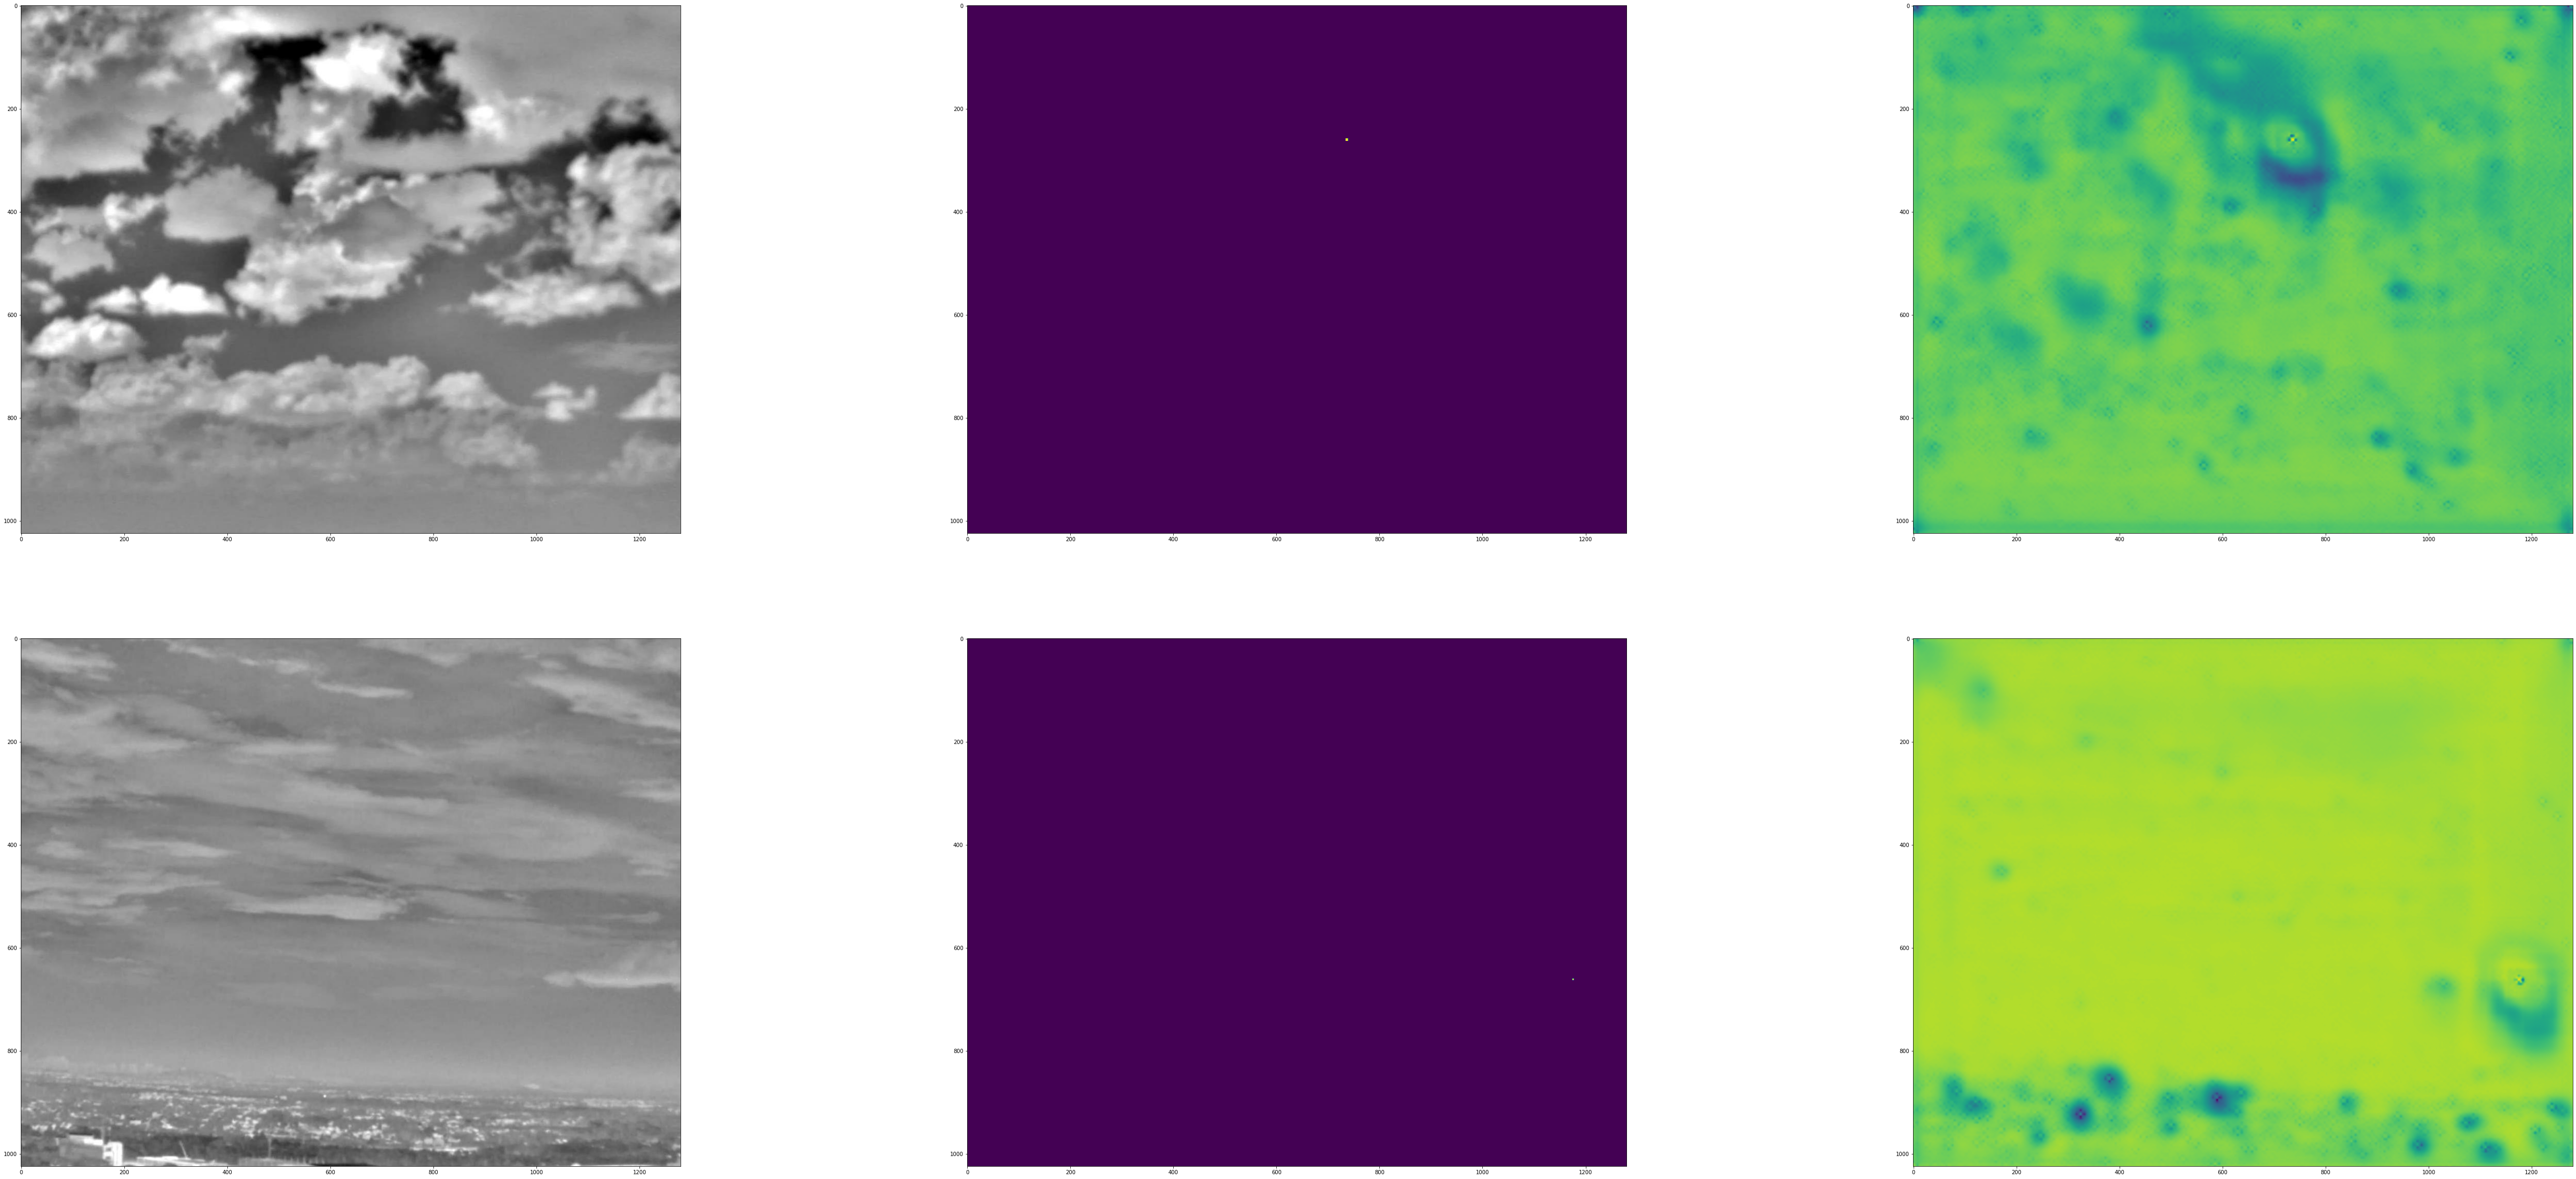

In [20]:
fig, ax = plt.subplots(2,3,figsize = (90,40))
for i, (data,targets) in enumerate(train_dataloader):
    #data, targets = data.to(device), targets.to(device)
    d1 = data
    t1 = targets
    break
for i in range(2):
    ax[i][0].imshow(d1[i].permute(1,2,0))
    ax[i][1].imshow(t1[i])
    ax[i][2].imshow((model(d1)[i]).cpu().detach().numpy()[0])
    
plt.savefig('test.png')

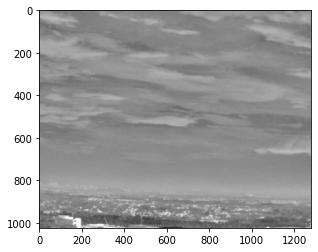

In [21]:
plt.imshow(d1[1].permute(1,2,0))

In [1]:
torch.max(transforms.ToTensor()(Image.open('/kaggle/input/nudtsirst/mask/Sample_2/frame_0000.png')))
plt.imshow()

NameError: name 'torch' is not defined